# **Compte rendu - TSIA 202**

---
---
#### _Jeanne MALÉCOT - Clément DARDARE_

### Imports utiles

In [71]:
import numpy as np
from scipy import signal as sig
from scipy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.widgets as wid

###### We copy the python script randproc.py directly since it is impossible to upload several files to eCampus, so we could not import them in the notebook.

##### _Randproc.py_

In [19]:
def acovb(X=None):

    Xc = X - np.mean(X)    
    m = 2 * X.size - 1
    I = np.abs(np.fft.fft(Xc,m)) ** 2 /  X.size
    gamma = np.real(np.fft.ifft(I))    
    gamma = gamma[0:X.size]
    return gamma

def myhann(M,flag='sym'):
    if flag=='periodic':
        om = 2.0*np.pi/M
        l  = np.arange(0,M)       
    else:
        om = 2.0*np.pi/(M+1)
        l  = np.arange(1,M+1)
    w =  0.5-0.5*np.cos(l*om)
    return w
    
def genAR(p,n,noiseSTD=1):
# Returns    
# X :   Generated AR process 
# phi : coefficients or recurrence equation 
#       X(t) = phi(1)X(t-1)+...+phi(p)X(t-p) + Z(t);
#       Z(t) is WN(0,1).
# p :   Order of AR filter
# n :   Number of output samples
# noiseSTD : STD of the white noise. Default = 1

    # random draw of int(p/2) complex roots inside the unit circle 
    nrc = int(p/2) #% number of complex roots

    # Set the module of the poles in the (0.5 0.999) interval
    rho = .5+0.499*np.sqrt(np.random.random_sample(nrc)) 
    theta = 2*np.pi*np.random.random_sample(nrc)
    zk = rho *np.exp(1.j *theta);
    #
    # Compute transient lenght
    zmax = zk[np.abs(zk)==np.max(np.abs(zk))]
    rhomax = np.abs(zmax)
    tau = -1./np.log(rhomax) 
    transient = int(5*tau)    #  we allow for some room
    
    zk = np.concatenate((zk, np.conjugate(zk)))
    if np.remainder(p,2): # we need to add one real positive root in the interval (0,1)
        realRoot = np.random.random_sample()
        zk =  np.concatenate(([realRoot], zk))
                                      
    coeff = np.poly(zk) # coefficients of polynomial p(z) = prod_k( z-z_k);
    coeff = np.real(coeff) # remove possible imag residuals due to limited precision
    
    
    phi = -coeff[1:];
                
    # White noise generation. Lenght = n+transient
    noise = noiseSTD*np.random.randn(n+transient)

    # AR signal generation
    X =  sig.lfilter([1], coeff, noise)
    
    # Removing the transient
    X=X[transient:]

    return X, phi
  
def drawZ_DTFT_AR(X,phi):
    # Draws the poles of the AR transfer function
    # Draws the DTFT and the positions of the poles
    coeff = np.concatenate(([1], -phi))
    zk    = np.roots(coeff)
    theta = np.angle(zk)
    
    
    plt.figure(figsize=(10,6))
    # Draw the unit circle
    t = np.linspace(-np.pi,np.pi,1024)
    plt.plot(np.sin(t),np.cos(t))
    plt.axis('equal')
    plt.grid()
    plt.plot(np.real(zk),np.imag(zk), 'x' )
    plt.title('Poles of the AR transfer function')
    
    
    plt.figure(figsize=(10,6))    
    # the smallest integer power of two that is not less than the size of X
    nPoints = np.int(np.exp2( np.ceil(np.log2(X.size))) )
    nu = np.linspace(-0.5, 0.5 - 1/nPoints, nPoints)
    omega = 2*np.pi*nu
    acf = acovb(X)
    PSD = np.real(np.fft.fft(acf,int(nPoints))) #
    plt.plot(omega,np.fft.fftshift(PSD)/max(PSD))
    plt.plot(theta,np.zeros_like(theta),'x')
    plt.title('PSD and phases of the poles')
       
    # Draw the filter energy transfer function |H(nu)|^2
    w, H = sig.freqz([1], coeff, omega)
    H2 = np.real( H*np.conj(H))
    plt.plot(omega,H2/max(H2))
    
    plt.legend(['Normalized PSD of the AR signal','Phases of the poles','Normalized Power transfer function |H|^2'])
    
def  detectPitch(X,minT,maxT)   :
# Returns the estimanted period of the input speech sample
# If the sample is not voiced, it returns 0
# Parameters : 
    # X input signal
    # minT minimum period
    # maxX maximum period
    
    gamma = acovb(X)
    rho   = gamma/gamma[0]     # autocorrelation function
    rho_bar = (rho[minT:])
    M = rho_bar.max()
    indexes = np.nonzero((rho)==M)
    T = indexes[0] 
    T=np.squeeze(T) 
    threshold = 0.5
    if M*X.size/(X.size-T)< threshold or T> maxT:
        T=0
        
    return T

---
---
## **Exercise 1:** Computing averages and covariances

### Experimental Results :
---

We simply use the code written in _covariance.py_ to show the experimental plots, that we prefered to run with Spyder. 


##### _White Noise with variance_ $\sigma$ :

![White Noise](images/wn.png "White noise")

##### _Causal AR process with coefficient_ $\phi$ :

![Causal AR process](images/ar1.png "Causal AR process")

##### _Sinusoidal process_ :

![Sinusoidal process](images/sinusoidal.png "Sinusoidal process")

### Comparison with theory
---

We have the followings ACF functions for these three models :

| **White noise** | **Causal AR process** | **Sinusoidal process** |
| :-: | :-: | :-: |
| $\gamma(\tau) = \left\{ \begin{array}{ll} \sigma^2 & si & \tau=0 \\ 0 & sinon  \end{array} \right.$| $\gamma(\tau) = \frac{\sigma^2 \phi ^{\lvert\tau\rvert}}{1 - \phi^2} $ |$\gamma(\tau) = \left\{ \begin{array}{ll} \frac{(A_0)^2}{2} + \sigma^2 & si & \tau=0 \\ \frac{(A_0)^2}{2}cos(\lambda_0h) & sinon  \end{array} \right.$ |

<Figure size 432x288 with 0 Axes>

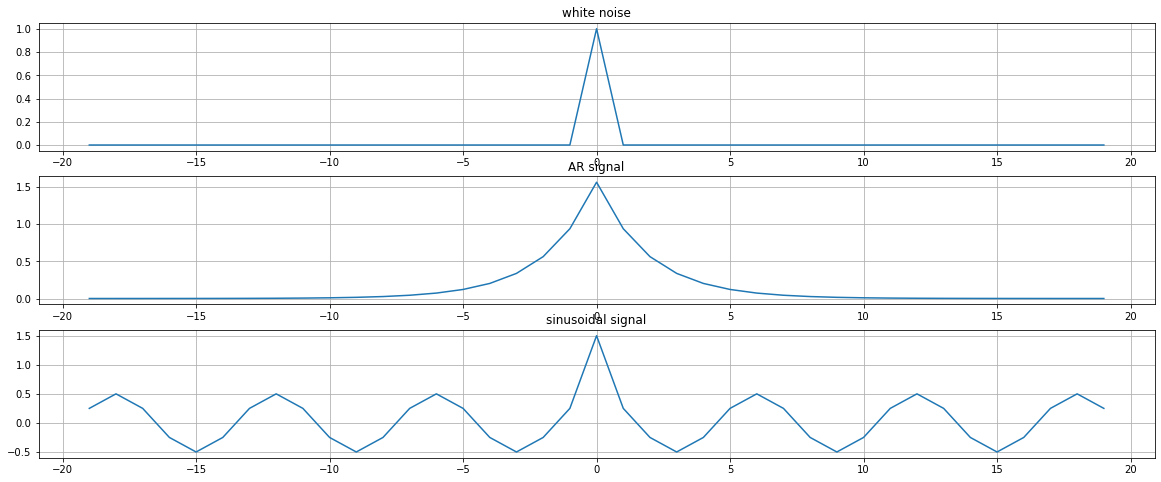

In [20]:
A0 = 1
w = np.pi/3
sigma = 1
H = 20  

# SIN
x1 = [A0**2/2*np.cos(w*k)for k in range(-19, 20)]
x1[len(x1)//2] += sigma*sigma

# AR
x2 = [0.6**abs(k)*sigma*sigma/(1-0.6*0.6) for k in range(-19, 20)]

# WN
x3 = [0 for k in range(-19, 20)]
x3[(len(x3))//2] = 1

# Echelle des temps
t = [k for k in range(-19, 20)]

plt.clf()
plt.figure(2, [H, 8])
plt.subplot(313, label='SIN')
plt.grid()
plt.plot(t, x1)
plt.title('sinusoidal signal')
plt.subplot(312, label='AR')
plt.grid()
plt.plot(t, x2)
plt.title('AR signal')
plt.subplot(311, label='WN')
plt.grid()
plt.plot(t, x3)
plt.title('white noise')
plt.show()


> Averages are assumed to be zero for all values. In practice, a slight random oscillation around 0 is observed, which is consistent with the theory.  
>For the autocovariances, there is a great similarity between the theoretical and experimental curves for the three processes.  
Moreover, according to the chosen values $ (A_0 = 1 ;
w = \frac{\pi}{3} ; \sigma = 1 )$, one can identify points of the practical curve with the formulas given in the table above.

### Transfert function
---

##### Generation of an AR(1) signal (method found in coviariance.py, used to plot the practical results)

In [21]:
# Generate an AR(1) signal
n = 2*H - 1 
Z = np.random.normal(0, 1, n)  # White noise
# Build the rational function P/Q
phi1 = 0.6
Pcoeffs = np.array([1.])
Qcoeffs = np.poly((phi1,))
# Use P/Q for filtering
X = sig.lfilter(Pcoeffs, Qcoeffs, Z)

C:\Users\jeann\AppData\Local\Temp\ipykernel_16108\3121051363.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nPoints = np.int(np.exp2( np.ceil(np.log2(X.size))) )


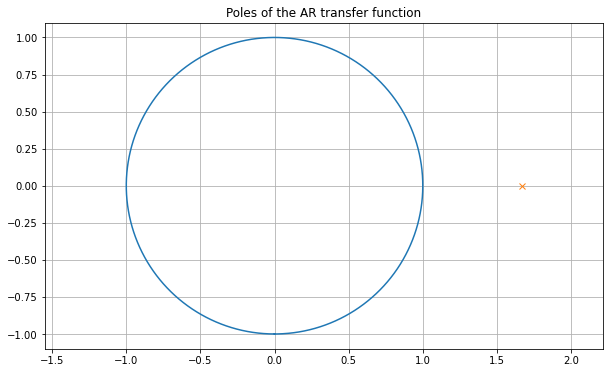

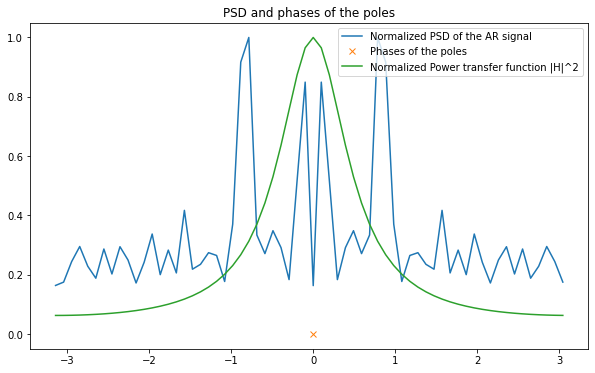

In [22]:
drawZ_DTFT_AR(X,np.array([1/phi1]))

---
---
## **Exercise 2:** Spectral density estimation and periodogram

### Question 1
---

$$\begin{align} I_n(\lambda) &=\frac{1}{2\pi n}\sum_{h=-n+1}^{n-1}\sum_{t=0}^{n-1-h}(X_t-\hat{\mu}_n)(X_{t+h}-\hat{\mu}_n)e^{-i\lambda h} \\ 
&= \frac{1}{2\pi n}\sum_{s=-n+1}^{n-1}\sum_{t=0}^{n-1+s}(X_t-\hat{\mu}_n)(X_s-\hat{\mu}_n)e^{-i\lambda(s-t)} \\
&= \frac{1}{2\pi n}\sum_{s=0}^{n-1}(X_s-\hat{\mu}_n)e^{-i\lambda s} \sum_{t=0}^{n-1}(X_t-\hat{\mu}_n)e^{i\lambda t} \\
&= \frac{2\pi}{n} \left| \frac{1}{2\pi} \sum_{s=0}^{n-1}(X_s-\hat{\mu}_n)e^{-i\lambda s} \right| ^2 \end{align} $$
$$ \boxed{ I_n(\lambda)= \frac{2\pi}{n} \left| DFT(X_i-\hat{\mu}_n) \right| ^2} $$

### Question 2
---

Wa can use this result to compute $I_n(2\pi \frac{k}{m})$.

In [28]:
def I_n(X, m):
    n = len(X)
    return (1/len(X)) * (np.abs(np.fft.fft(X-np.mean(X), n=m)))**2

In [38]:
X1, X2, X3 = [], [], []
H= 80
Nit = 100
n = 2*H-1
tc = np.arange(-(H-1), H)

# WN
sigma = 1.
X1 = np.random.normal(0, sigma, n)
WN = np.random.normal(0, sigma, 100)  # signal de white noise plus long

# AR
Z = np.random.normal(0, 1, n)
phi1 = 0.6
Pcoeffs = np.array([1.])
Qcoeffs = np.poly((phi1,))
X2 = sig.lfilter(Pcoeffs, Qcoeffs, Z)

# SIN
A_0 = 1.
omega = np.pi/3.
phi = np.pi + 2*np.pi*np.random.random_sample()
X3 = A_0 * np.cos(omega*tc+phi) + np.random.normal(0, 1, n)

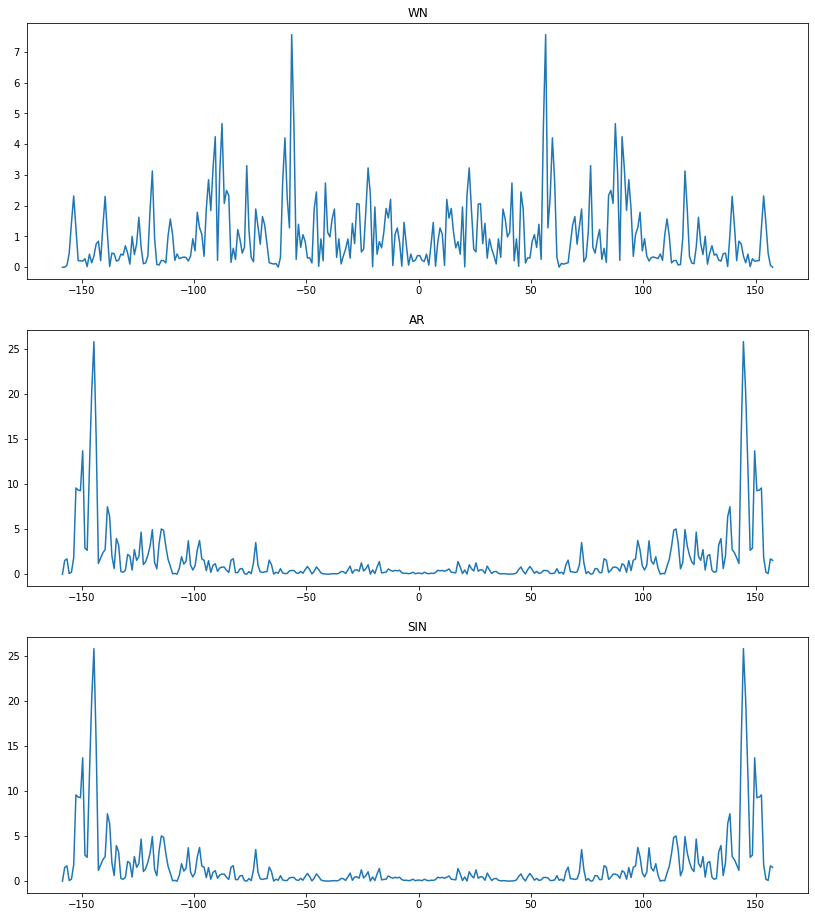

In [39]:
# We compute In for each process
I1 = I_n(X1, 2*n-1)
I2 = I_n(X2, 2*n-1)
I3 = I_n(X2, 2*n-1)

tbis = [k+0.5 for k in range(-len(I1)//2, len(I1)//2)]

fig = plt.figure(figsize=(14,16))
fig.add_subplot(312).set_title('AR')
plt.plot (tbis, I2)

fig.add_subplot(311).set_title('WN')
plt.plot (tbis, I1)

fig.add_subplot(313).set_title('SIN')
plt.plot (tbis, I3)

plt.show()

### Question 3
---

We have :
$$ \begin{align} I_n(2\pi \frac{k}{m}) &= \frac{1}{2\pi} \sum_{h=-n+1}^{n-1}{\hat{\gamma}_n(h) e^{-2i \pi h \frac{k}{m}}} \\
&= \frac{1}{2\pi} \sum_{s=0}^{2n-2}{\hat{\gamma}_n(s - n +1) e^{-2i \pi (s - n +1) \frac{k}{m}}}  \end{align} $$
Then we choose m = 2n - 1, which gives :
$$ \boxed{I_n(2\pi \frac{k}{m}) = e^{-2i \pi \frac{1-n}{m}} \sum_{s=0}^{m-1}{\hat{\gamma}_n(s - n +1) e^{-2i \pi s\frac{k}{m}}}} $$ 

We just have to apply the DFT to $I_n$ to find $\hat{\gamma}_n$ with a shift.  
So we can take the first terms of the sequence above and apply the DFT.

In [49]:
def gamma(X):
    m = len(X)
    I = I_n(X, m)
    gamma_n = np.real(np.fft.ifft(I))
    return gamma_n[:m//2]   

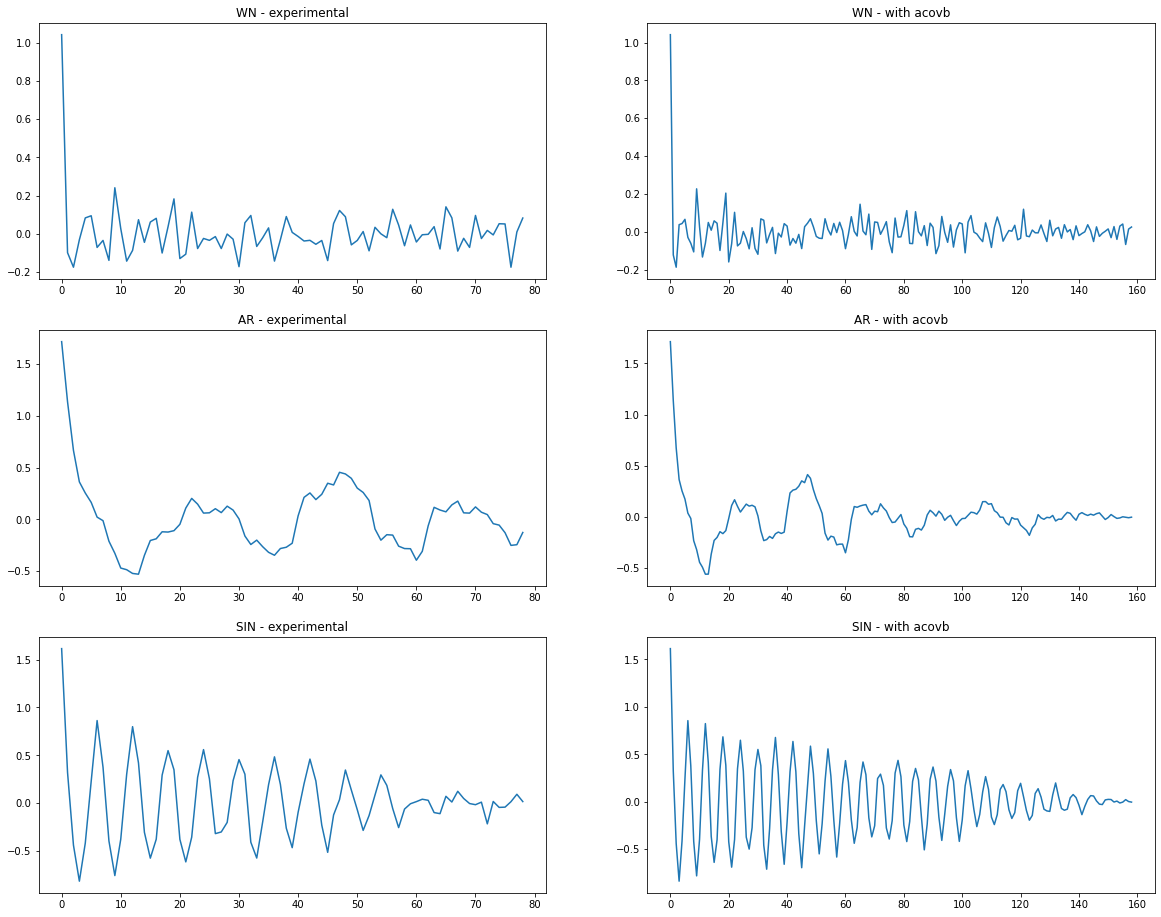

In [50]:
I_1 = gamma(X1)
I_1b = acovb(X1)
I_2 = gamma(X2)
I_2b = acovb(X2)
I_3 = gamma(X3)
I_3b = acovb(X3)

tbis = [k+0.5 for k in range(-len(I_1)//2, len(I_1)//2)]

fig = plt.figure(figsize=(20,16))

fig.add_subplot(321).set_title('WN - experimental')
plt.plot (I_1)

fig.add_subplot(322).set_title('WN - with acovb')
plt.plot (I_1b)

fig.add_subplot(323).set_title('AR - experimental')
plt.plot (I_2)

fig.add_subplot(324).set_title('AR - with acovb')
plt.plot (I_2b)

fig.add_subplot(325).set_title('SIN - experimental')
plt.plot (I_3)

fig.add_subplot(326).set_title('SIN - with acovb')
plt.plot (I_3b)

plt.show()

> We observes that both methods give a similar results, that should be correct.

### Question 4
---

On a :
$$ \Delta = I_n(\lambda) - f(\lambda) $$

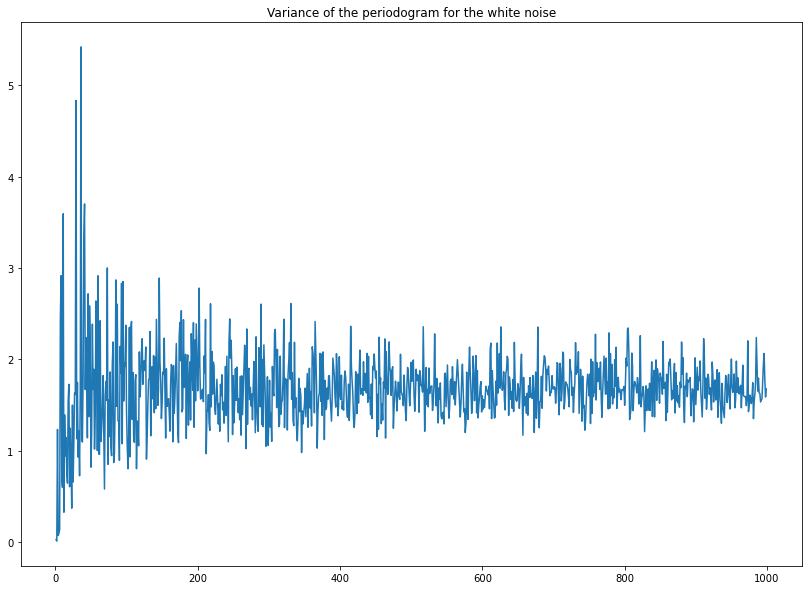

In [63]:
var=[]
sigma = 1

for n in range(1, 1000):
    X = np.random.normal(0, sigma, n)
    m = 2*n-1

    I = I_n(X,m)
    f = np.array([sigma**2 /(np.pi *2)]*m)
    delta2 = (I - f)**2

    var.append(np.mean(delta2))

abs = [k for k in range(1,1000)]

plt.figure(figsize=(14,10))
plt.title("Variance of the periodogram for the white noise")
plt.plot(abs, var)
plt.show()


We can see that the variance decreases, but its limit does not seems to be zero. Then this estimator is not constistent.

---
---
## Exercice 3

### **Part 1**

### Question 1
---

We propose to reason by recurrence on t.  
We want to show :
$$ \boxed{\forall h\geq 0, \mathbb{E}(X_{t-h}Z_t) = 0}$$
**Initialisation :**
$$ \forall h\geq 0, X_{0-h} = 0 \Rightarrow \mathbb{E}(X_{t-0}Z_t) = 0$$
**Hereditary :**   
We suppose $ \forall h\geq k, \mathbb{E}(X_{t-k}Z_t) =0$ for any fixed k.
$$ \begin{align} \mathbb{E}(X_{t+1-h}Z_t+1) &= \mathbb{E}\left[  \left( \sum_{k=1}^p (\phi_k X_{t+1-k} + Z_{t+1-k}) \right) Z_{t+1}\right] \\
&= \underbrace{ \sum_{k=1}^p \phi_k \mathbb{E} (X_{t+1-k} Z_{t+1})}_{= 0 (R.H.)} + \underbrace{\mathbb{E} (Z_{t+1-k} Z_{t+1})}_{=0} \end{align} $$
**Conclusion :**
We have the result according to the recurrence principle.

### Question 2
---

$$ \gamma (h) = Cov(X_{t+h}, X_{t}) = \mathbb{E}(X_{t+h} X_{t}) =  \sum_{k=0}^p {\phi_k \mathbb{E}(X_{t+h-k}X_t)}  + \underbrace{\mathbb{E}(Z_{t+h} X_{t})}_{=0} =  \sum_{k=0}^p {\gamma(h-k)}$$

### Question 3
---

$$ \gamma(0) = \mathbb{E}(X_t^2) = \sum_{k=0}^p {\phi_k \mathbb{E}(X_{t-k}X_t)} + \mathbb{E}(Z_{t} X_{t}) = \sum_{k=0}^p {\phi_k \gamma(-k)} + \underbrace{\mathbb{E}(Z_{t} X_{t})}_{=\sigma^2}$$
Then :
$$ \boxed{\gamma(0) = \sum_{k=0}^p {\phi_k \gamma(-k)} + \sigma^2} $$

### Question 4
---

$$ \forall k \geq 0, \gamma(k) - \sum_{i=0}^p {\phi_i \gamma(k-i)} = 0  $$ 
So with the previous question we have :
$$ \boxed{\Gamma_{p+1} = (\gamma(i-j))_{0 \leq i,j \leq p}}



### **Part 2 :**

### Question 1
---

We generate n=1000 samples of an AR(4) with genAR:

In [66]:
n=1000
p=4

X,phi = genAR(p,n)

array([-0.88878446, -0.44949085, -0.32763716, -0.47125958])

### Question 2
---

We produce the estimator gamma with acovb:

In [79]:
gamma= acovb(X)
Gamma_hat = la.toeplitz( gamma[:p+1])


### Question 3
---

We compute the intermediate vector v and the produit with gamma:

In [84]:
v1 = np.zeros(p+1)
v1[0]=1
c = np.dot(la.inv(Gamma_hat),v1)

[1.         0.87475327 0.43762137 0.31631746 0.46636754]
[1.         0.88878446 0.44949085 0.32763716 0.47125958]


Now we can estimate the variance and the AR coefficients:

In [85]:
sigma2Est = 1/c[0]
estimated_coeff= c* sigma2Est
estimated_coeff[0] = 1
coeff=np.concatenate(([1],-phi))
print (estimated_coeff )
print (coeff)

[1.         0.87475327 0.43762137 0.31631746 0.46636754]
[1.         0.88878446 0.44949085 0.32763716 0.47125958]


We computer the relative error:

In [88]:
err= coeff -     estimated_coeff
rel_err =  np.linalg.norm(err)/np.linalg.norm(coeff) 
print('Relative error {0:.2%} '.format(rel_err))

Relative error 1.45% 


We show the estimated PSD:

[-3.14159265 -3.13545673 -3.12932081 ...  3.12318488  3.12932081
  3.13545673]


C:\Users\jeann\AppData\Local\Temp\ipykernel_16108\243025463.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nPoints = np.int(np.exp2( np.ceil(np.log2(X.size))))


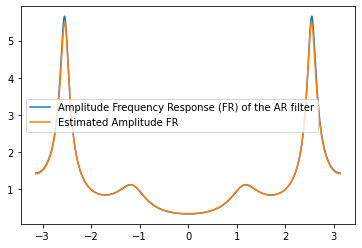

In [91]:
plt.figure()
nPoints = np.int(np.exp2( np.ceil(np.log2(X.size))))
nu = np.linspace(-0.5, 0.5 - 1/nPoints, nPoints)
omega = 2*np.pi*nu
w1, H1 = sig.freqz([1], coeff, omega)
w2, H2 = sig.freqz([1], estimated_coeff, omega)
print(w1)
plt.plot(w1,np.abs(H1))
plt.plot(w2,np.abs(H2))
plt.legend(['Amplitude Frequency Response (FR) of the AR filter','Estimated Amplitude FR' ])

We compare with the frequencies associated to the poles of $\frac{1}{\phi(z^{-1})}$ :

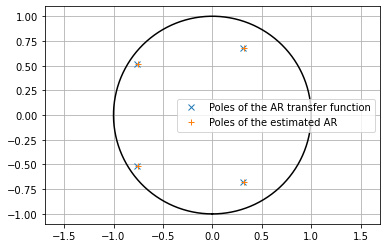

In [92]:
plt.figure()
plt.axis('equal')
plt.grid()
zk    = np.roots(coeff)
plt.plot(np.real(zk),np.imag(zk), 'x' )
zk2 = np.roots(estimated_coeff)
plt.plot(np.real(zk2),np.imag(zk2), '+' )
plt.legend(['Poles of the AR transfer function','Poles of the estimated AR'])
t = np.linspace(-np.pi,np.pi,1000)
plt.plot(np.sin(t),np.cos(t), 'black')
